In [20]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [21]:
warnings.filterwarnings('ignore')

In [22]:
# creating a variable for the data
df = pd.read_csv('../data/world_development_data_imputed.csv')

In [23]:
# creating variables for the target column and the rest of the data
target = df['LifeExpBirth']
df1 = df.drop('LifeExpBirth', axis=1)

In [24]:
df1

,Year,Country,Region,SubRegion,SurfAreaSqKm,PopTotal,PopDens,PopGrowth%,GDP,GDPGrowth%,...,GNI/CapAtlas,GNIAtlas,Imports%GDP,IndValAdd%GDP,InflConsPric%,MerchTrade%GDP,MobileSubs/100,MortRateU5,NetMigr,UrbanPopGrowth%
0,2000.0,Afghanistan,Asia,Southern Asia,652860.0,19542982.0,29.963329,1.443803,1.801248e+10,-5.206288,...,916.923281,1.778669e+10,41.312634,17.178775,37.611028,52.777048,0.000000,129.3,-1007135.0,1.861377
1,2000.0,Malta,Europe,Southern Europe,320.0,390087.0,1219.021875,0.645267,4.323339e+09,19.681791,...,10950.000000,4.273280e+09,128.374581,26.939987,-4.512396,135.682159,28.667475,7.6,1799.0,0.952299
2,2000.0,Belgium,Europe,Western Europe,30530.0,10251250.0,338.548547,0.242518,2.367925e+11,3.716679,...,25890.000000,2.654129e+11,69.682740,24.943833,2.014617,154.515900,54.840339,5.9,32262.0,0.308431
3,2000.0,Marshall Islands,Oceania,Micronesia,180.0,54224.0,301.244444,0.721838,1.153475e+08,1.354079,...,2770.000000,1.500075e+08,100.812761,12.681072,-0.454689,55.484514,0.824358,42.1,-1323.0,1.492787
4,2000.0,Mauritania,Africa,Sub-Saharan Africa,1030700.0,2695003.0,2.614731,2.799182,1.779521e+09,-3.918026,...,710.000000,1.907497e+09,33.423259,29.951850,6.351587,45.461676,0.567717,98.8,-2997.0,2.476860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4439,2021.0,Morocco,Africa,Northern Africa,446550.0,37076584.0,83.075474,1.051484,1.428666e+11,7.929668,...,3620.000000,1.364081e+11,42.020038,26.080984,3.244246,65.709558,137.459274,18.0,-46242.0,1.886932
4440,2021.0,Montenegro,Europe,Southern Europe,13810.0,619211.0,46.037993,-0.337763,5.861431e+09,13.043464,...,9370.000000,5.800493e+09,62.195638,14.835495,4.726248,59.217626,178.395786,2.3,-101.0,0.161803
4441,2021.0,Mongolia,Asia,Eastern Asia,1564116.0,3347782.0,2.149449,1.609371,1.528644e+10,1.636770,...,3730.000000,1.247452e+10,60.549214,37.075572,14.420065,105.237048,140.012223,14.7,0.0,1.795620
4442,2021.0,Kenya,Africa,Sub-Saharan Africa,580370.0,53005614.0,93.132821,1.942761,1.097037e+11,7.590489,...,2080.000000,1.100273e+11,19.915101,17.152436,4.330748,23.971853,122.790239,37.2,-52549.0,3.706017


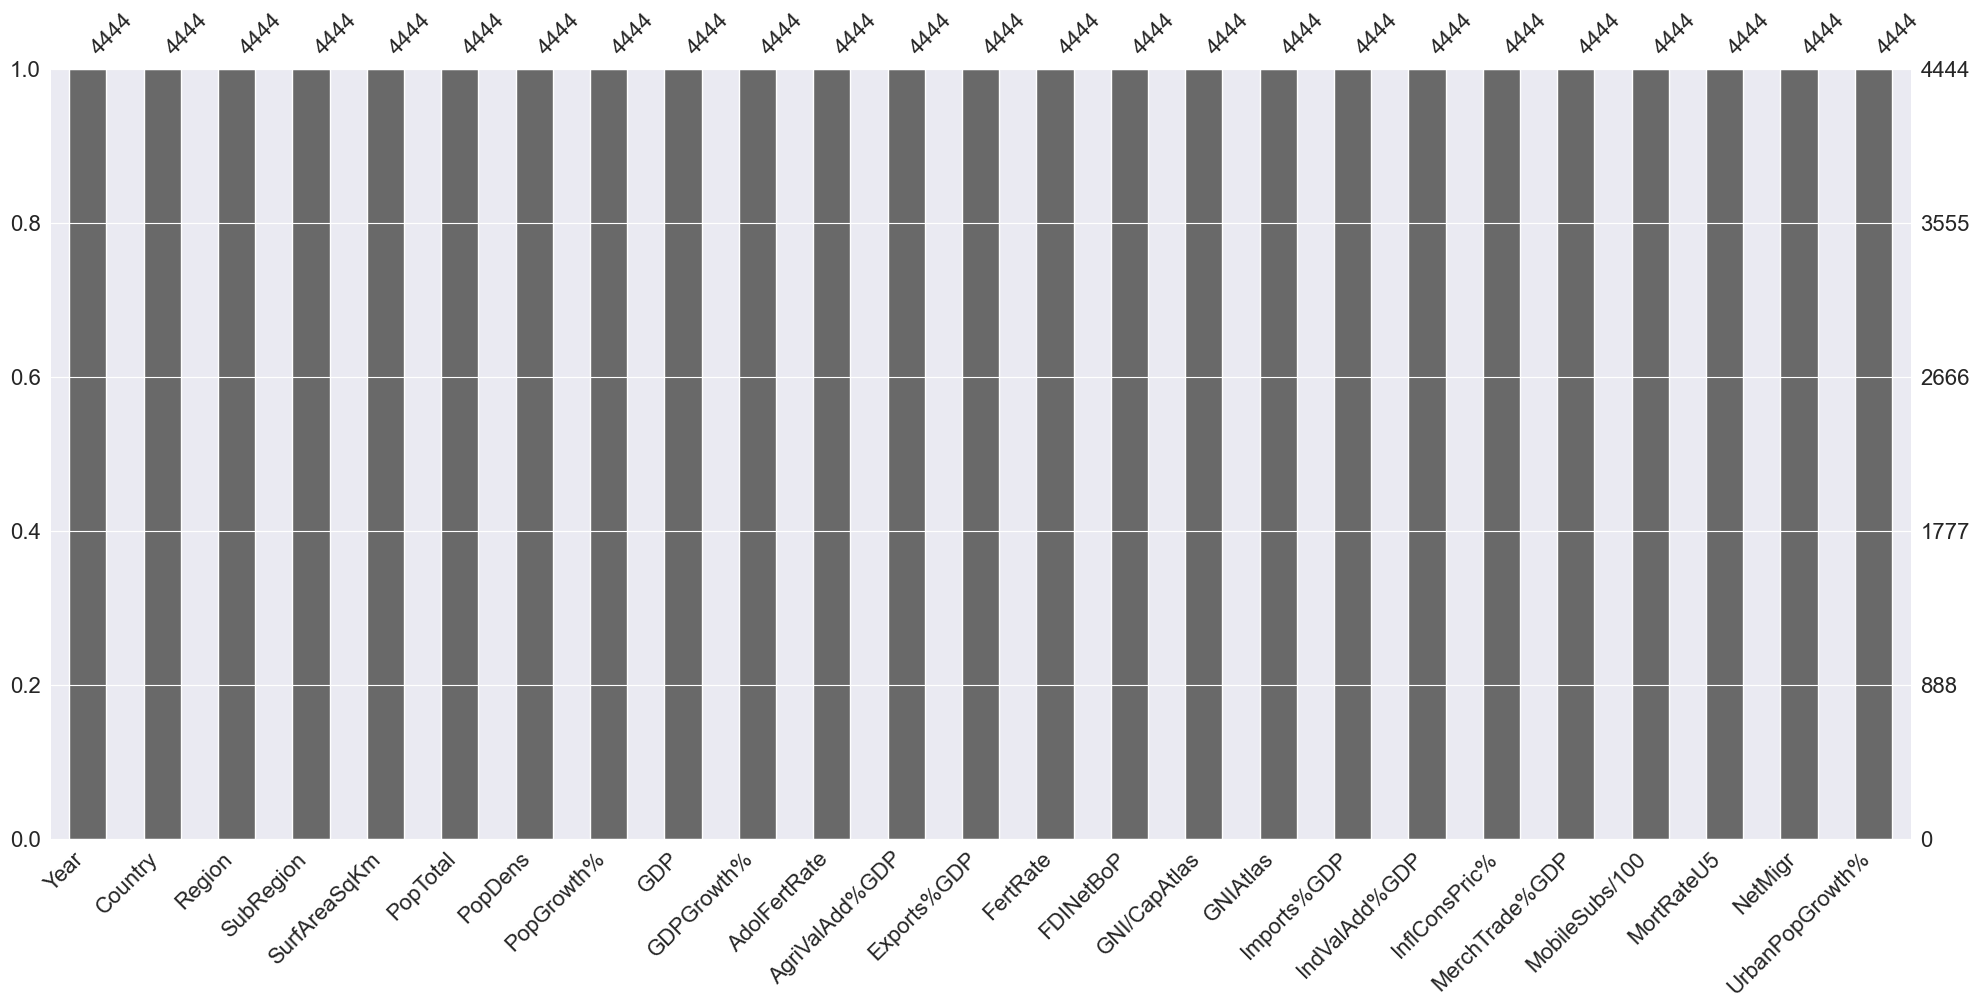

In [25]:
# checking if there's any missing data
msno.bar(df1);

## Feature selection

In [26]:
correlation_matrix = df1.drop(['Year', 'Country', 'Region', 'SubRegion'], axis=1).corr()

<Axes: >

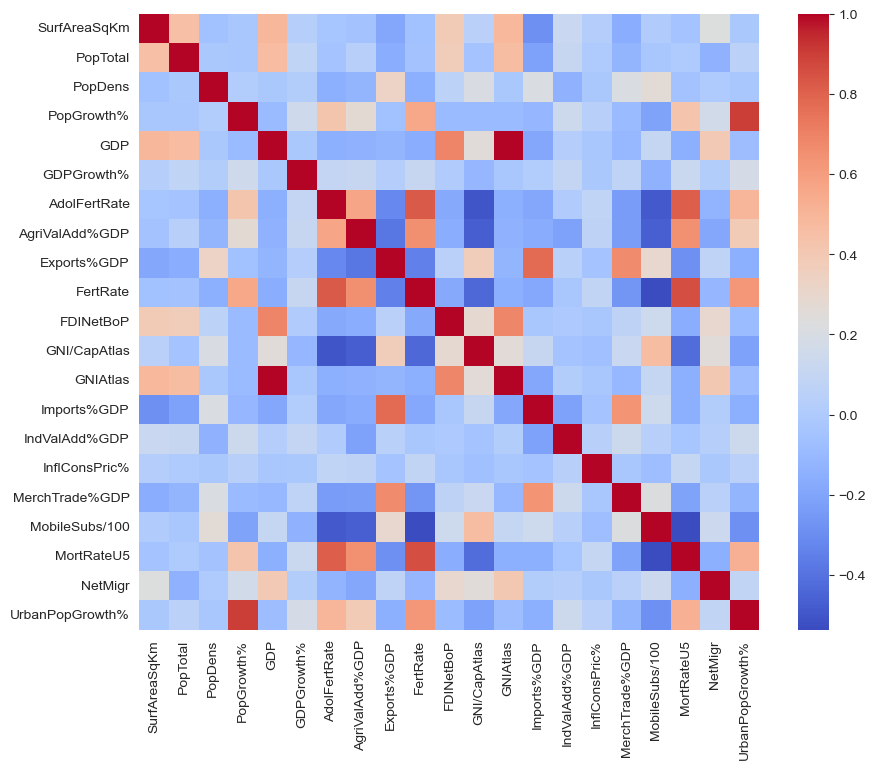

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')

In [28]:
(df1[['GNIAtlas', 'GDP']]).corr()

,GNIAtlas,GDP
GNIAtlas,1.000000,0.999298
GDP,0.999298,1.000000


In [29]:
columns_to_use = [
    'SubRegion',
    'SurfAreaSqKm',
    'PopTotal',
    'PopDens',
    'PopGrowth%',
    'GDP',
    'GDPGrowth%',
    'AdolFertRate',
    'AgriValAdd%GDP',
    'Exports%GDP',
    'FertRate',
    'FDINetBoP',
    'GNI/CapAtlas',
    'GNIAtlas',
    'Imports%GDP',
    'IndValAdd%GDP',
    'InflConsPric%',
    'MerchTrade%GDP',
    'MobileSubs/100',
    'MortRateU5',
    'NetMigr',
    'UrbanPopGrowth%'
]

In [30]:
# Scaling numeric features to use SelectKBest
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df1[columns_to_use].drop('SubRegion', axis=1))

In [31]:
df1[scaler.get_feature_names_out()] = scaled_data

In [32]:
# selecting 10 best numerical features using SelectKbest
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit_transform(df1.drop(['Year', 'Region', 'SubRegion', 'Country'], axis=1), target)
selector.get_feature_names_out()

array(['PopDens', 'PopGrowth%', 'AdolFertRate', 'AgriValAdd%GDP',
       'FertRate', 'GNI/CapAtlas', 'InflConsPric%', 'MobileSubs/100',
       'MortRateU5', 'UrbanPopGrowth%'], dtype=object)

In [33]:
df2 = df1[['SubRegion', 'PopDens', 'PopGrowth%', 'AdolFertRate', 'AgriValAdd%GDP', 'FertRate', 'GNI/CapAtlas', 'InflConsPric%', 'MobileSubs/100', 'MortRateU5', 'UrbanPopGrowth%']]

In [34]:
df3 = df1.drop(['Year', 'Country', 'Region'], axis=1)

In [35]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = ohe.fit_transform(df2[['SubRegion']])

In [36]:
df2[ohe.get_feature_names_out()] = encoded
df3[ohe.get_feature_names_out()] = encoded

df2.drop('SubRegion', axis=1, inplace=True)
df3.drop('SubRegion', axis=1, inplace=True)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df3, target, train_size=0.7, random_state=42)

## Modeling

#### XGBoost


In [ ]:
xgb_model_gs = XGBRegressor()

param_grid_xgb = {
    'alpha': np.arange(0.009, 0.014, 0.001),
    'reg_lambda': np.arange(0.9, 1.1, 0.05),
    'learning_rate': [0.22, 0.26, 0.005]
}

gs_xgb = GridSearchCV(xgb_model_gs, param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-3)
gs_xgb.fit(X_train, y_train)

print(f'best params: {gs_xgb.best_params_}')
print(f'best score: {gs_xgb.best_score_}')

In [ ]:
best_model_xgb = gs_xgb.best_estimator_
test_score = gs_xgb.score(X_test, y_test)

print("Test Score with Best Parameters:", test_score)

In [39]:
xgb_model = XGBRegressor(learning_rate=0.245, reg_lambda=0.95, reg_alpha=0.01)
xgb_model.fit(X_train, y_train)

pred_train = xgb_model.predict(X_train)
pred_test = xgb_model.predict(X_test)

print(f'train score: {mean_squared_error(y_train, pred_train)}')
print(f'test score: {mean_squared_error(y_test, pred_test)}')

train score: 0.0729069723903165
test score: 1.2695108276760656


#### CatBoost

In [40]:
cb_model = CatBoostRegressor()
cb_model.fit(X_train, y_train)

pred_train = cb_model.predict(X_train)
pred_test = cb_model.predict(X_test)

print(f'train score: {mean_squared_error(y_train, pred_train)}')
print(f'test score: {mean_squared_error(y_test, pred_test)}')

Learning rate set to 0.048982
0:	learn: 8.4114901	total: 60.5ms	remaining: 1m
1:	learn: 8.0738607	total: 62.1ms	remaining: 31s
2:	learn: 7.7685946	total: 63.2ms	remaining: 21s
3:	learn: 7.4883658	total: 64.4ms	remaining: 16s
4:	learn: 7.2043847	total: 65.6ms	remaining: 13s
5:	learn: 6.9445647	total: 66.8ms	remaining: 11.1s
6:	learn: 6.6910920	total: 67.9ms	remaining: 9.63s
7:	learn: 6.4751754	total: 68.9ms	remaining: 8.55s
8:	learn: 6.2405241	total: 70.4ms	remaining: 7.76s
9:	learn: 6.0231419	total: 71.5ms	remaining: 7.08s
10:	learn: 5.8162626	total: 72.5ms	remaining: 6.52s
11:	learn: 5.6287242	total: 73.6ms	remaining: 6.06s
12:	learn: 5.4494690	total: 74.7ms	remaining: 5.67s
13:	learn: 5.2888572	total: 75.8ms	remaining: 5.33s
14:	learn: 5.1260719	total: 77ms	remaining: 5.06s
15:	learn: 4.9702511	total: 78.3ms	remaining: 4.82s
16:	learn: 4.8264145	total: 79.5ms	remaining: 4.6s
17:	learn: 4.6944968	total: 80.8ms	remaining: 4.41s
18:	learn: 4.5571825	total: 82ms	remaining: 4.23s
19:	lear